In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
from training import toy

In [3]:
batch_size = 1

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3)
trainloader = torch.utils.data.DataLoader(trainset, batch_size)

In [53]:
import matplotlib.pyplot as plt

def plot(eval):
    plt.xlim(-2, 2)
    plt.ylim(-3, 3)
    t = np.linspace(-2, 2, 50)

    plt.plot(t, t**3, color="blue") # Actual function

    means, deviations = np.zeros(len(t)), np.zeros(len(t))
    with torch.no_grad():
        for i, input in enumerate(t):
            mean, variance = eval(torch.tensor([input], dtype=torch.float))
            means[i], deviations[i] = mean.numpy(), variance.numpy()
    higher_bound = means + 3 * deviations
    lower_bound = means - 3 * deviations
    plt.plot(t, means, color="red") # Averaged predictions
    plt.fill_between(t, lower_bound, higher_bound, color="lightgrey")

    xs, ys = zip(*((x.numpy(), y.numpy()) for (x, y) in trainloader))
    plt.scatter(xs, ys, s=4, color="blue")

Epoch 0: loss 0.00011240519233979285
Epoch 10: loss 0.019016563892364502
Epoch 20: loss 0.01238215435296297
Epoch 30: loss 0.006303947418928146
Final loss 0.0029399972409009933


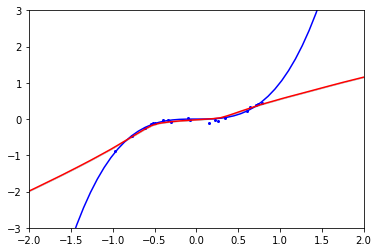

In [30]:
# Point estimator with L2 regularization

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
for epoch in range(40):
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")
print(f"Final loss {loss}")
plot(lambda input: (model(input), torch.tensor(0)))

Epoch 0: loss 0.005222423002123833
Epoch 10: loss 0.02261117286980152
Epoch 20: loss 0.01148289442062378
Epoch 30: loss 0.004223838448524475
Final loss 0.001502353698015213


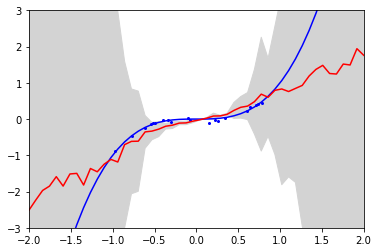

In [91]:
# SWAG trained with Adam and L2 regularization

from training import swag
import importlib
importlib.reload(swag)

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(model, 1, 10)
for epoch in range(40):
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    wrapper.update(epoch)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")

print(f"Final loss {loss}")

def eval_swag(input):
    return wrapper.sample(input, 100, model, 1)

plot(eval_swag)